# ROI Fitinspector
To inspect individuals ROIs (individual cells) for experimentally determined donor-lifetime trace and best-fit. 

In [1]:
import pandas as pd
import time
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import tkinter as tk
from tkinter import filedialog
from tifffile import TiffFile
from PDE_Display import get_cell_image
%load_ext watermark
from PDE_Display import Config

In [2]:
ROOT = tk.Tk()
ROOT.withdraw() #closes the tkinter window again. just a cleanup
ROOT.attributes('-topmost', True)

''

In [3]:
#Cell: remember the last results folder in your home directory in a file 'jalink_pde_config.ini'
cfg=Config()
myPath = cfg.readorwrite('myPath','c:\\') #this reads/writes by default in \users\username folder
#if the file exists and has a key myPath it is read into variable myPath, else the file is made and set to C:\\

users_base_path = filedialog.askopenfilename(title="Choose a single well fit file", filetype=(('csv files', '*.csv'),("all files", "*.*")))
fileName=users_base_path.split("/")[-1] # next, determine the names of the corresponding _fit.csv and _tau.csv files
resultpath=users_base_path.rstrip(fileName)# the path without the filename
cfg.write('myPath', resultpath)

users_base_path = Path(users_base_path)
labelmapfile = Path(users_base_path.parent.parent,'labelmap_data',users_base_path.name[:-8]+'_I_mean_labelmap.tif')
meanfile = Path(users_base_path.parent.parent,'intensity_data',users_base_path.name[:-8]+'_I_mean.tif')
wellName=fileName[0:len(fileName)-8]
resultfile = wellName+'_tau.csv' 
fitfile = wellName+'_fit.csv'
errfile = wellName+'_errors.csv'
print(users_base_path)

D:\temp\Screening_Result\2019\12\05\caged\results\B02_tau.csv


In [4]:
def fit_function(x, a, b, c, d):
    return a + b / (1 + np.exp(-4 * (x - d)/c))

def whaterror(error):
    errorlist = ["ROI does not excist",
                 "ROI smaller than min_pix",
                 "ROI mean intensity smaller than min_int",
                 "ROI intensitytrace has one or more zeros",
                 "Trace starts outside of the stabilityrange",
                 "Trace has NaNs",
                 "Trace gave a runtime error in the fit",
                 "Trace error on the rate is bigger than maxerror",
                 "Fit does not start around the start of the data"]
    errors = []
    for i in range(len(errorlist) + 1):
        if int(error) & (1 << i):
            errors.append(errorlist[i])
    return errors

In [5]:
#This cell contains switches and settings that control the flow and behaviour of the analysis below.
#you can manually edit them
autoScroll=True #automatically scrolls through the cells
randomCells=True #only show a few (max_nroi) examples
pickSpecificCell=False #only show (a) specific cell(s)
if pickSpecificCell==True:
    randomCells=False
fixYScale = True
max_nroi=10            #<<<<<<<<<< adjust this one to set how many are plotted maximally per well
scrollTime=0.05        #autoscroll delay, in s. Set to a (few) s if you want to inspect trace by trace

In [6]:
fit = pd.read_csv(Path(resultpath,fitfile))
fit = fit.replace([np.inf, -np.inf], np.nan)
condition=fit['condition'][0]
lifetimetraces = np.loadtxt(Path(resultpath,resultfile))
frameinterval = fit['frameinterval(s)'][0]
forskendpoint = True # or false, depending if you have chemical stimulation or caged-cAMP release
nroi = min(lifetimetraces.shape[0], max_nroi) #plot no more than max_nroi cells if they exist
ntime = lifetimetraces.shape[1]

fit_sel = fit[fit['breakdown_time(s)'] > 2]#these are conditions added by Rolf to reject some cells\n",
fit_noerrors = fit_sel[fit_sel['error']==0]
fit_hasdarkframe = fit_sel[fit_sel['error']==8]
fit_errorfree = pd.concat([fit_noerrors,fit_hasdarkframe])
print('There are '+ str(len(lifetimetraces)) +' individual cells in the FOV of well '+wellName)
print('There are '+ str(len(fit_errorfree)) +' individual cells had no fitting errors and can be included in final analysis. From these for '+ str(len(fit_hasdarkframe)) +' ROIs the dark frame had to be cured.')
print('Frameinterval was '+ str(round(frameinterval,1)) + ' seconds.')

There are 413 individual cells in the FOV of well B02
There are 283 individual cells had no fitting errors and can be included in final analysis. From these for 0 ROIs the dark frame had to be cured.
Frameinterval was 2.0 seconds.


In [7]:
#This jptnb Cell: implement flexibility in picking cells.
#It would pick the first max_nroi cells, unless randomCells=True or pickSpecificCells=True
selectedCells=np.arange(0, max_nroi,1) #limit 0-max_nroi
if randomCells==True:
    selectedCells = np.random.randint(1, len(lifetimetraces), size=max_nroi)
if pickSpecificCell==True:
    ff=(input("enter valid roinumbers of cell(s) separated by a space and press Enter to accept: "))
    selectedCells=np.asarray(ff.split(" ")).astype((np.int))
    selectedCells -= 1 #trace_id is always one behing the ROI_nr, this converts entered ROI_nr to trace_id used for indexing
    if selectedCells.max()>len(lifetimetraces):
        print("INVALID ROI Nr(s). Only Roi1 will be shown")
        selectedCells=np.arange(1)

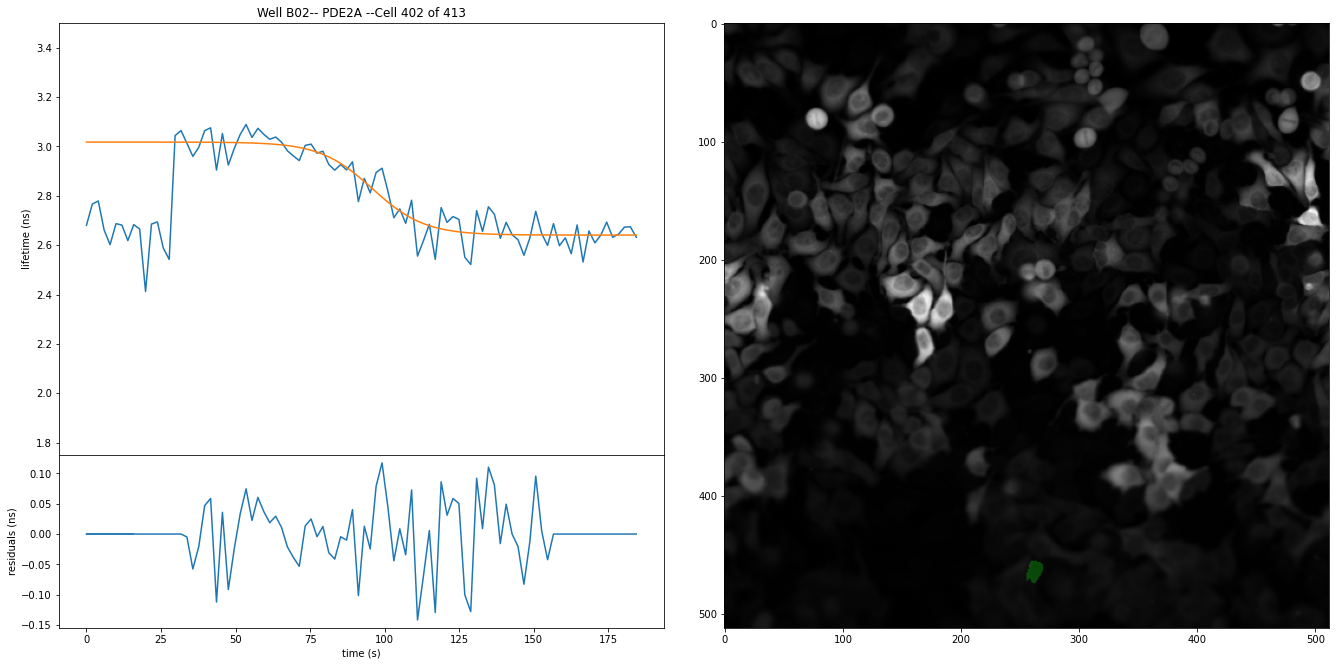

RMSD = 0.058 ns     MAPE = 1.7 %
Mean initial intensity of this ROI was 15 MGV.
No errors!
-------------------------------------------------


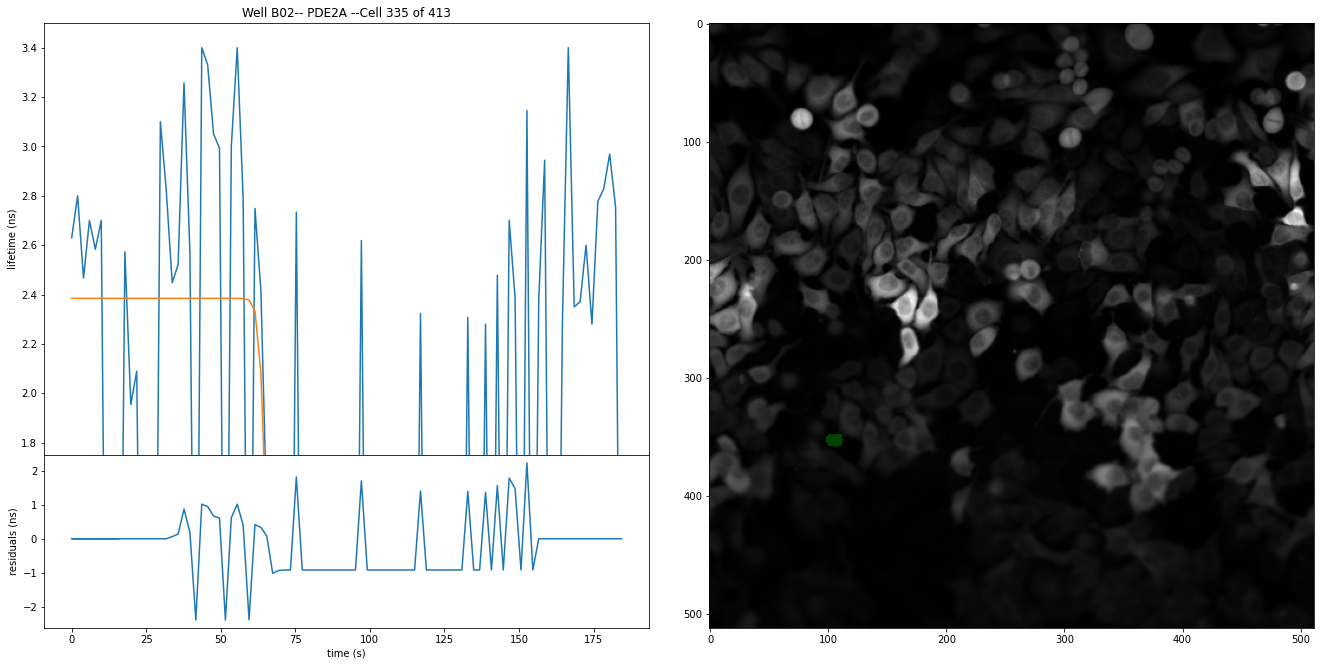

RMSD = 1.238 ns     MAPE = nan %
Mean initial intensity of this ROI was NaN!
['ROI intensitytrace has one or more zeros', 'Trace error on the rate is bigger than maxerror']
-------------------------------------------------


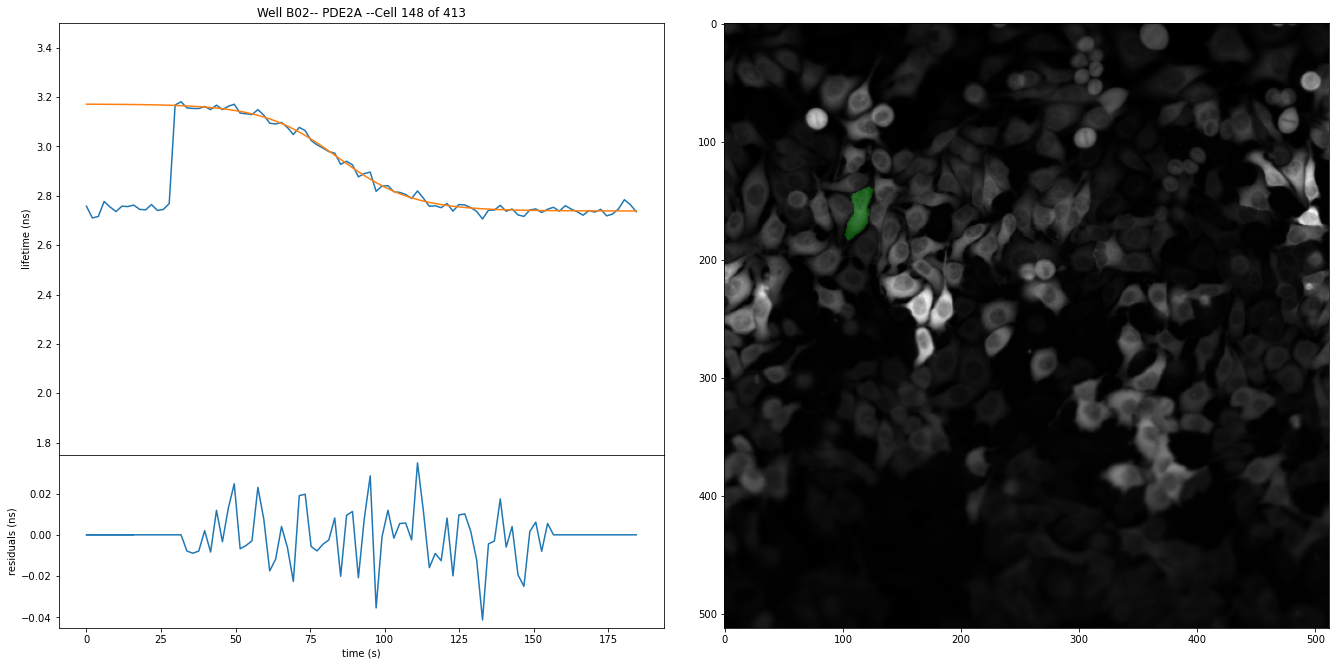

RMSD = 0.015 ns     MAPE = 0.4 %
Mean initial intensity of this ROI was 54 MGV.
No errors!
-------------------------------------------------


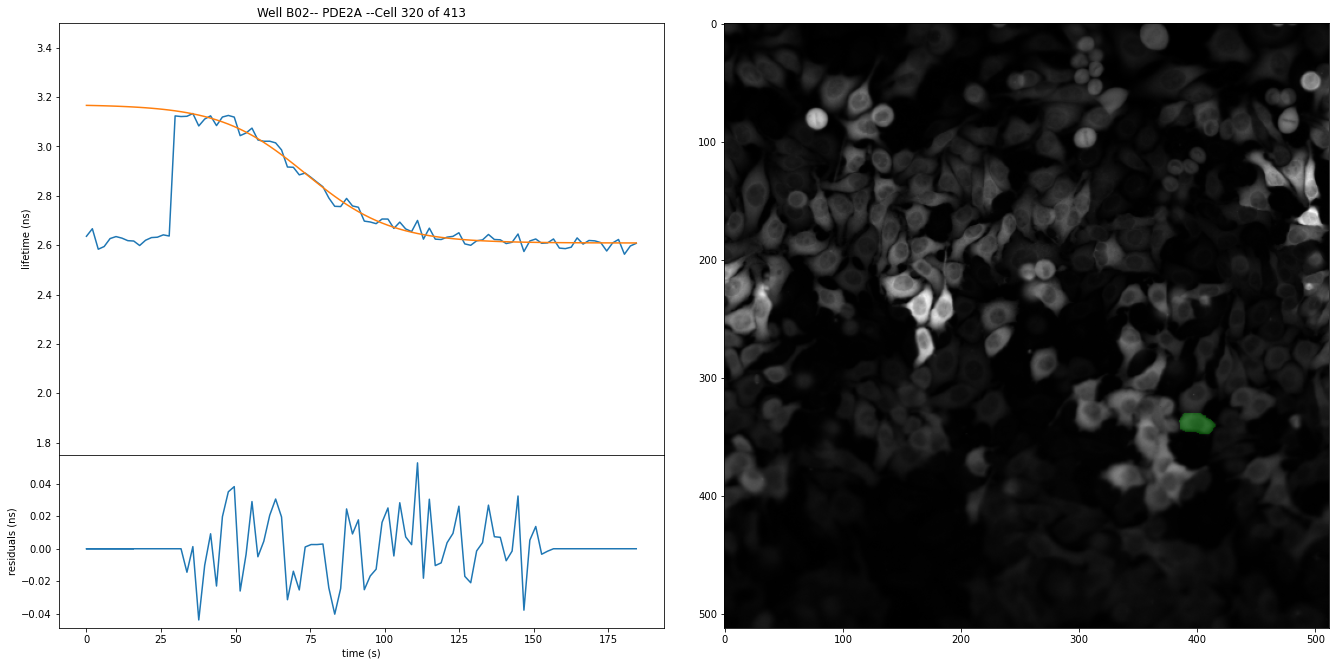

RMSD = 0.021 ns     MAPE = 0.6 %
Mean initial intensity of this ROI was 71 MGV.
No errors!
-------------------------------------------------


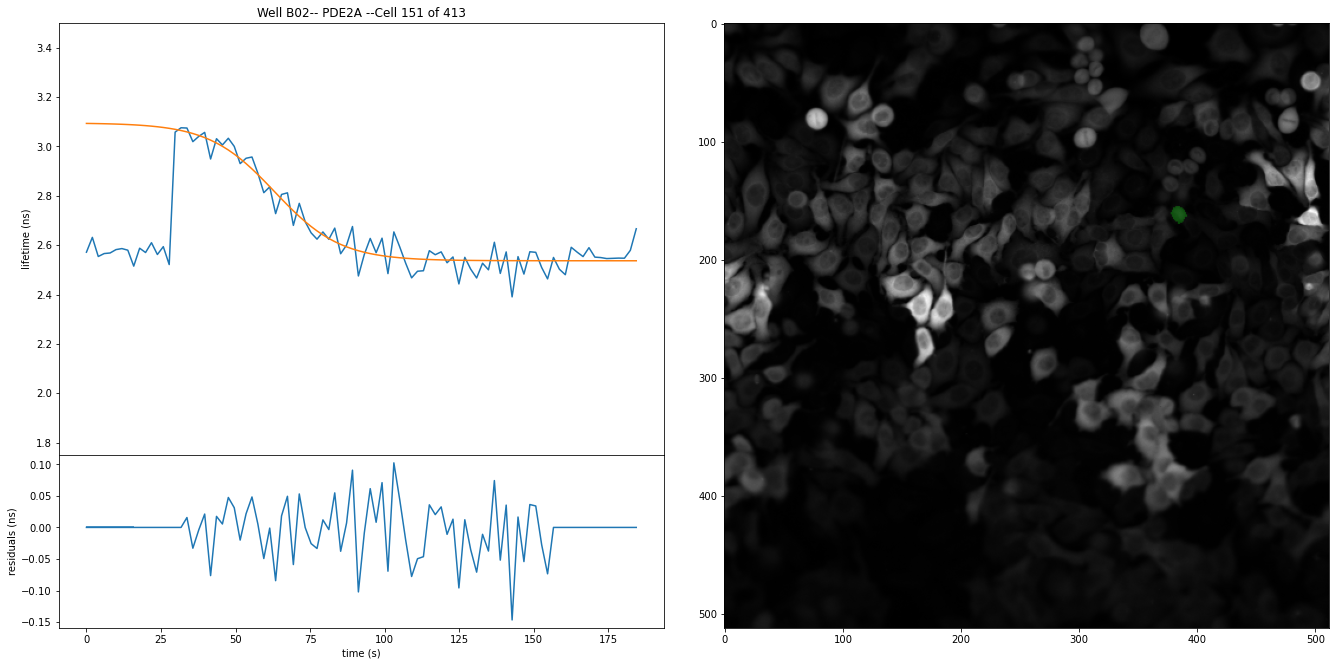

RMSD = 0.050 ns     MAPE = 1.5 %
Mean initial intensity of this ROI was 39 MGV.
No errors!
-------------------------------------------------


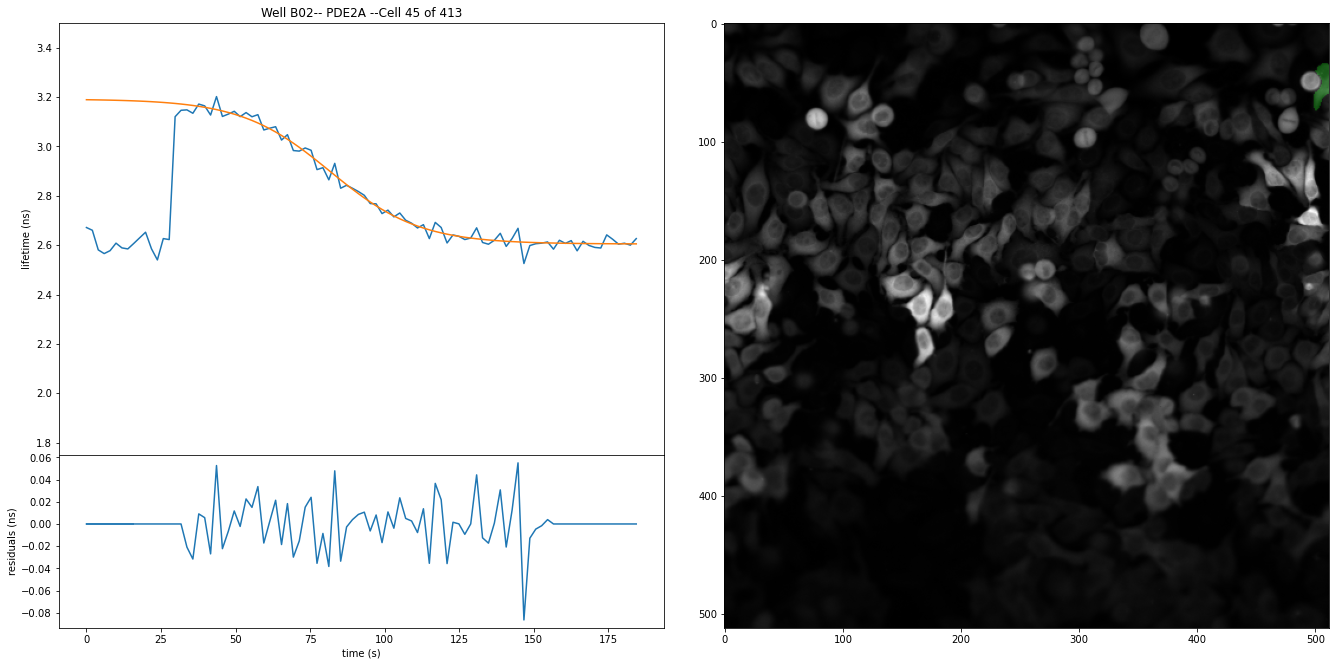

RMSD = 0.023 ns     MAPE = 0.6 %
Mean initial intensity of this ROI was 53 MGV.
No errors!
-------------------------------------------------


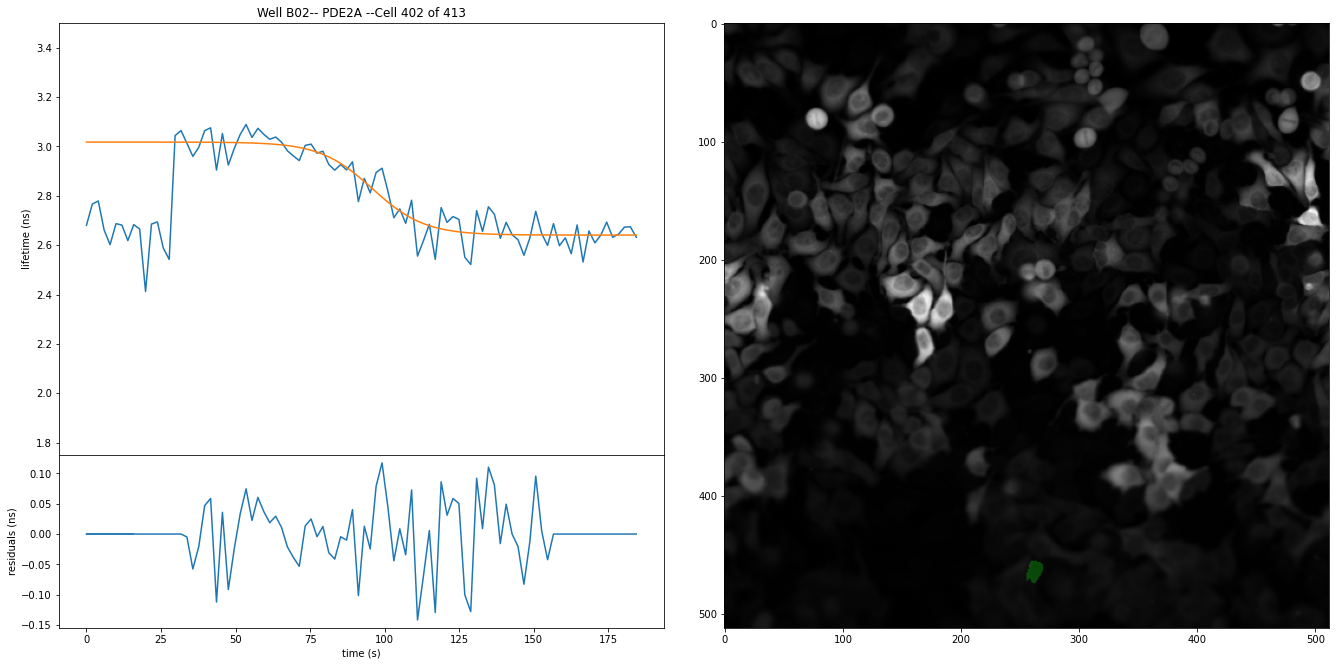

RMSD = 0.058 ns     MAPE = 1.7 %
Mean initial intensity of this ROI was 15 MGV.
No errors!
-------------------------------------------------


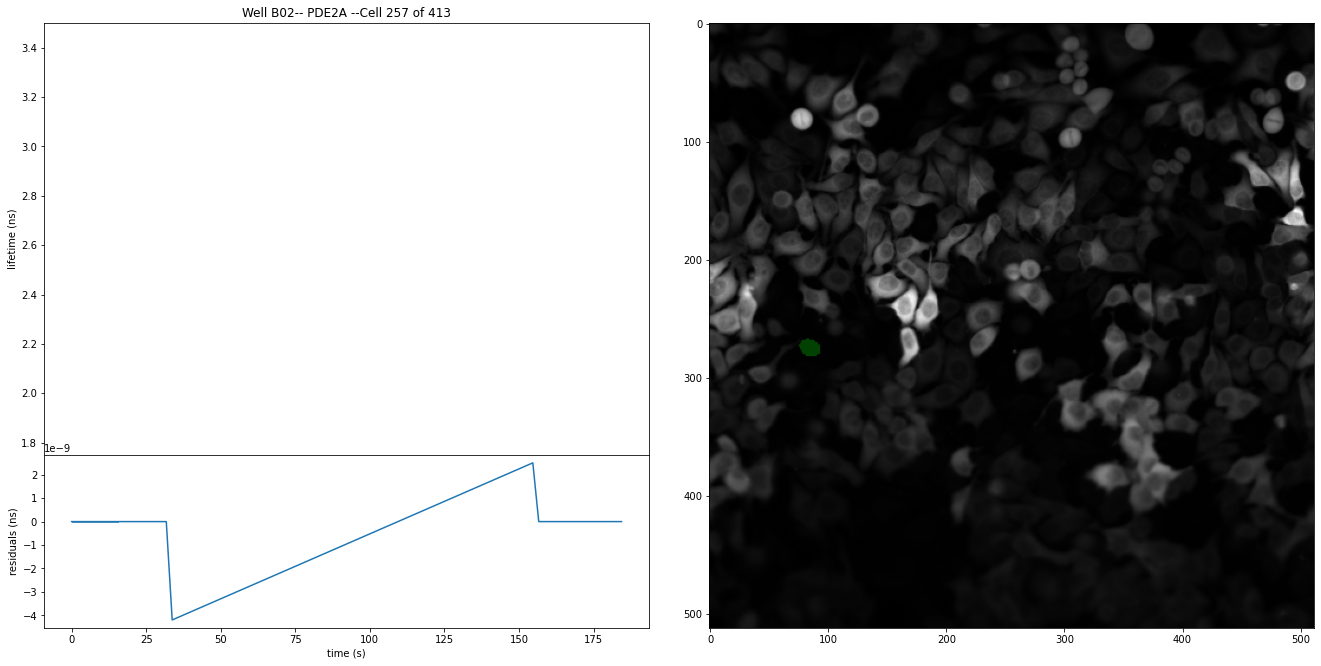

RMSD = 0.000 ns     MAPE = nan %
Mean initial intensity of this ROI was NaN!
['ROI intensitytrace has one or more zeros', 'Trace starts outside of the stabilityrange', 'Fit does not start around the start of the data']
-------------------------------------------------


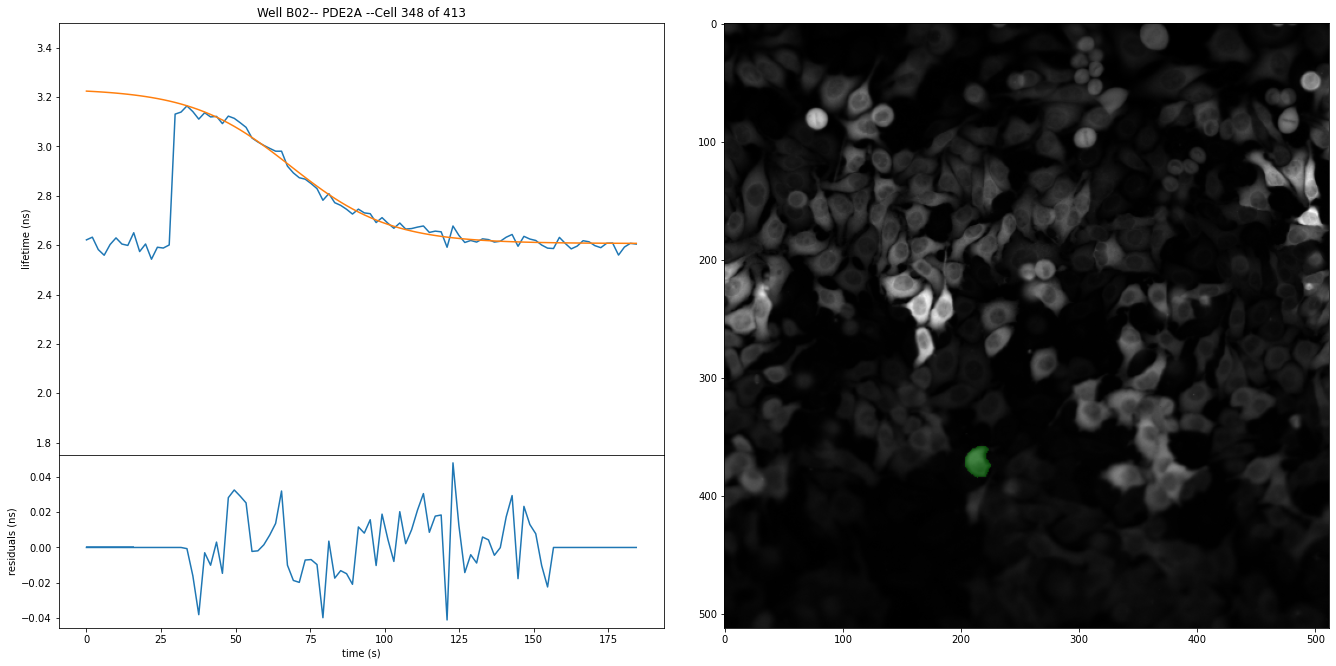

RMSD = 0.018 ns     MAPE = 0.5 %
Mean initial intensity of this ROI was 79 MGV.
No errors!
-------------------------------------------------


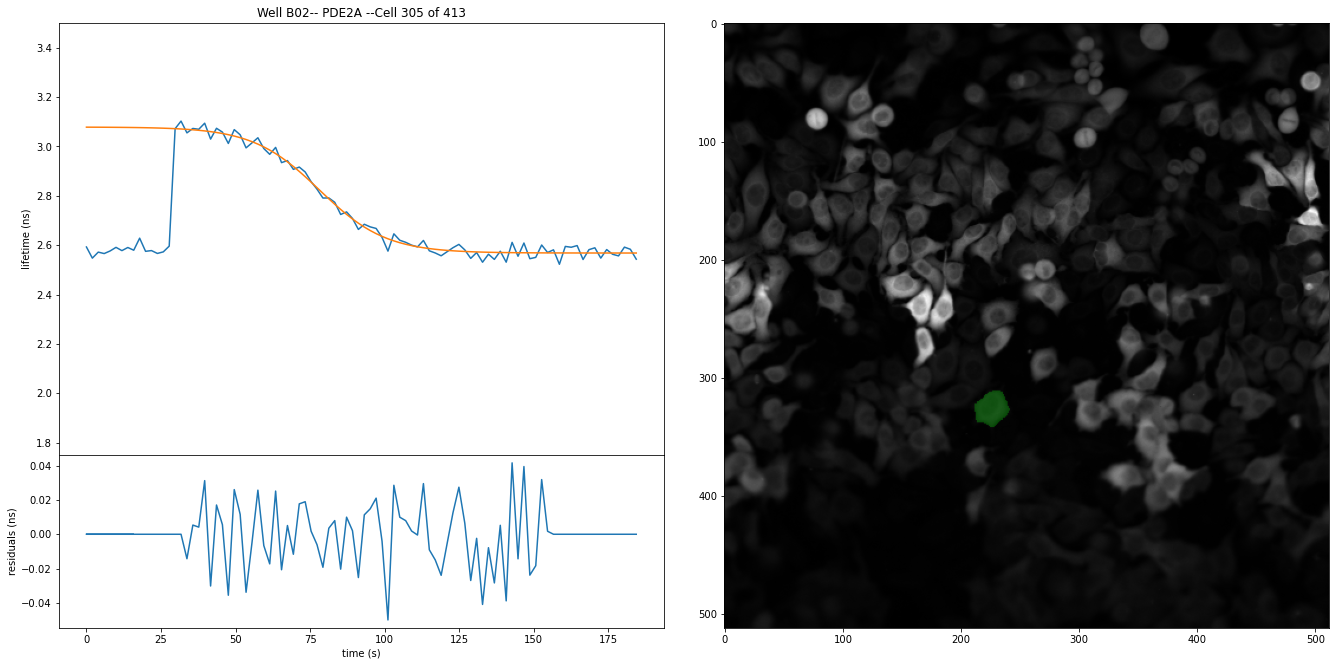

RMSD = 0.021 ns     MAPE = 0.7 %
Mean initial intensity of this ROI was 36 MGV.
No errors!
-------------------------------------------------


In [8]:
lifetimetraces = np.loadtxt(Path(users_base_path.parent.parent,'results',resultfile))
errors = np.loadtxt(Path(users_base_path.parent.parent,'results',errfile))
fitvalues = pd.read_csv(Path(users_base_path.parent.parent,'results',fitfile))
# find the fit-range
fitrange = np.zeros(shape=2, dtype=int)
lifetimetraces_selected = lifetimetraces[errors==0] #>>>>> this is needed to account for rejecting bad traces prior to fitting
mean_trace = np.mean(lifetimetraces_selected, axis=0)
d_mean_trace = np.diff(mean_trace)
fitrange[0] = np.argmax(mean_trace[0:int(150 / frameinterval)])  # maximum in the first 150 seconds
fitrange[1] = ntime
if forskendpoint:
    # 3 frames before maximum increase after peak.
    fitrange[1] = fitrange[0] + np.argmax(d_mean_trace[fitrange[0]:]) - 1

for trace_id in selectedCells:
    fit_vals= fit.loc[trace_id,:]
    fit_vals
    xdat = np.arange(0, ntime * frameinterval, frameinterval)
    ydat = lifetimetraces[trace_id]   
    yfit = fit_function(xdat,fit_vals['start(ns)'],fit_vals['range(ns)'],fit_vals['breakdown_time(s)'],fit_vals['midpoint(s)'])
    #print(wellName,"  ", condition,"  ", "Cell ", trace_id,  '       n_x =', len(xdat), '  n_y =', len(ydat),'  n_yfit =', len(yfit))
    
    xdat_selected = xdat[fitrange[0]:fitrange[1]]
    ydat_selected = ydat[fitrange[0]:fitrange[1]]
    yfit_selected = yfit[fitrange[0]:fitrange[1]]
    
    yresid = ydat - yfit #generate residuals but only for fit region
    yresid[0:fitrange[0]]=0
    yresid[fitrange[1]:len(yresid)]=0    
    
    rect_fit = [0.1, 0.5, 1, 1] #triple plot the stuff
    rect_resid = [0.1, 0.1, 1, 0.4]
    rect_image = [1.2, 0.1, 1, 1.4]
    fig = plt.figure(figsize = (6*1.4, 6))
    pltFit = fig.add_axes(rect_fit)
    pltResid = fig.add_axes(rect_resid)
    pltImg = fig.add_axes(rect_image)
    pltFit.set_title("Well "+wellName+'-- '+condition+' --Cell '+str(trace_id+1)+' of '+str(len(lifetimetraces)))
    pltFit.set_ylabel('lifetime (ns)')
    if fixYScale==True:
        pltFit.set_ylim(1.75, 3.5)
    pltResid.set_ylabel('residuals (ns)')
    pltResid.set_xlabel('time (s)')
    pltFit.plot(xdat, ydat, label="exp data")
    pltFit.plot(xdat, yfit, label='fit')
    pltResid.plot(xdat, yresid)
    pltResid.hlines(0,0,len('time (s)')*frameinterval)
    highlighted_ROI = get_cell_image(labelmapfile, meanfile,trace_id+1)
    pltImg.imshow(highlighted_ROI)
    plt.show()
   
    # printing 2 measures of fit quality: RMSD and MAPE
    RMSD = fit.RMSD[trace_id] # RMSD = np.sqrt(SSresid / len(ydat[fitrange[0]:fitrange[1]]))
    MAPE = fit.MAPE[trace_id] # MAPE = (100/len(ydat_selected))*sum(abs(ydat_selected-yfit_selected) / ydat_selected)
    # MAPE below 1% is a roughly good measure for goodness of fit
    CorrROInr = int(fit.ROI_nr[trace_id])
    # printout of the mean intensity value of the ROI
    mean_init_int = 256*fit.Mean_init_int[trace_id]/np.max(fit.Mean_init_int)
    print("RMSD = %.3f ns"%RMSD,"   ","MAPE = %.1f"%MAPE, "%")
    #print('The ROI number registerred in the dataframe:', CorrROInr)
    if np.isnan(mean_init_int):
        print ('Mean initial intensity of this ROI was NaN!')
    else:
        print('Mean initial intensity of this ROI was '+ str(int(mean_init_int)) + ' MGV.')
    
    # printout of the possible error mesaage for this ROI
    lifetimetrace = lifetimetraces[trace_id]
    error = errors[trace_id]
    fitvalue = fitvalues.iloc[trace_id]
    if whaterror(error) == []:
        print ('No errors!')
    else:
        print(whaterror(error))
    print('-------------------------------------------------')
    
      #trace_id+=1 #next part controls how they are shown sequentially
    if autoScroll==True:
        time.sleep(scrollTime)
    else:
        a=input("type Enter for Next Trace, or press Stop button [] on top to Stop: ")


In [9]:
print("Package versions used to generate this jupyter notebook:")
%watermark --iversions

Package versions used to generate this jupyter notebook:
numpy     : 1.20.2
pandas    : 1.2.4
matplotlib: 3.4.1

